# 10X Genomics Jupyter Notebook Tutorial (adapted to the [5k PBMCs dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/5k_pbmc_protein_v3))

*N.B. This notebook was adapted from: http://cf.10xgenomics.com/supp/cell-exp/notebook_tutorial-3.0.0.html*

This notebook demonstrates:
 + loading a feature-barcode matrix in HDF5 format
 + loading analysis files in CSV format
 + plotting UMI and feature (gene) count distributions
 + plotting clustering results and gene-specific expression in tSNE space

Data:
 + Go to the [5k Peripheral blood mononuclear cells (PBMCs) from a healthy donor with cell surface proteins (v3 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/5k_pbmc_protein_v3) page.
 + Download the `Feature / cell matrix HDF5 (filtered)` (.h5 format) and `Clustering analysis` (.tar format) files. 
 + Move the downloaded files to the current foler.

Note:
 + This requires the following Python packages: Matplotlib, NumPy, SciPy, Pandas, h5py. 
 + The easiest way to obtain these packages (as well as Jupyter Notebook) is to install [Anaconda](https://www.continuum.io/downloads).

In [1]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import h5py

np.random.seed(0)

FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['feature_ids', 'feature_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename):
    with h5py.File(filename) as f:
        if u'version' in f.attrs:
            if f.attrs['version'] > 2:
                raise ValueError('Matrix HDF5 file format version (%d) is an newer version that is not supported by this function.' % f.attrs['version'])
        else:
            raise ValueError('Matrix HDF5 file format version is an older version that is not supported by this function.')
        
        feature_ids = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['id']]
        feature_names = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['name']]        
        barcodes = list(f['matrix']['barcodes'][:])
        matrix = sp_sparse.csc_matrix((f['matrix']['data'], f['matrix']['indices'], f['matrix']['indptr']), shape=f['matrix']['shape'])
        return FeatureBCMatrix(feature_ids, feature_names, barcodes, matrix)

def get_expression(fbm, gene_name):
    try:
        gene_index = fbm.feature_names.index(gene_name)
    except ValueError:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return fbm.matrix[gene_index, :].toarray().squeeze()

In [2]:
#specify path to the feature matrix file
filtered_matrix_h5 = "5k_pbmc_protein_v3/outs/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5"
%time feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5)

CPU times: user 13.7 s, sys: 909 ms, total: 14.6 s
Wall time: 14.7 s


In [3]:
# untar the secondary analysis 
# alternatively, copy these to the command line (omitting the initial '!' character)
!tar -xzf 5k_pbmc_protein_v3/outs/5k_pbmc_protein_v3_analysis.tar.gz analysis/

In [4]:
# load tSNE and graph clustering
tsne = pd.read_csv("analysis/tsne/2_components/projection.csv")
clusters = pd.read_csv("analysis/clustering/graphclust/clusters.csv")

In [5]:
# calculate UMIs and genes per cell
umis_per_cell = np.asarray(feature_bc_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((feature_bc_matrix.matrix > 0).sum(axis=0)).squeeze()

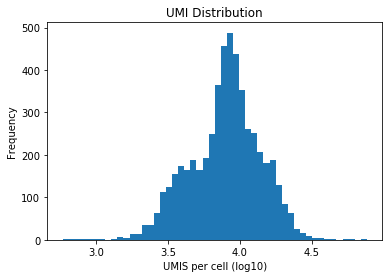

In [6]:
# plot UMIs per cell
plt.hist(np.log10(umis_per_cell), bins=50)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

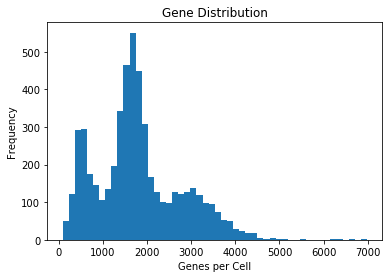

In [7]:
# plot genes per cell
plt.hist(genes_per_cell, bins=50)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

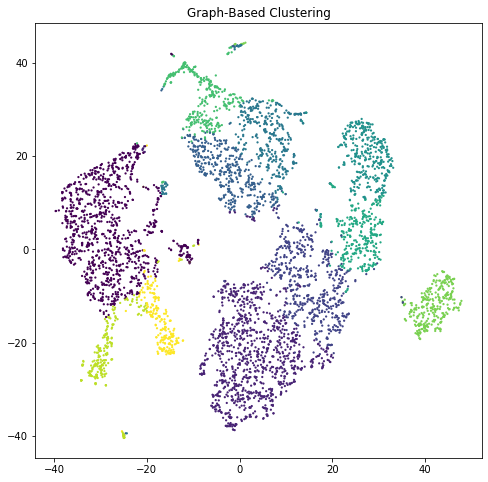

In [8]:
# plot clusters in TSNE space
plt.figure(figsize=(8, 8))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0, s=5)
plt.title('Graph-Based Clustering')
plt.show()

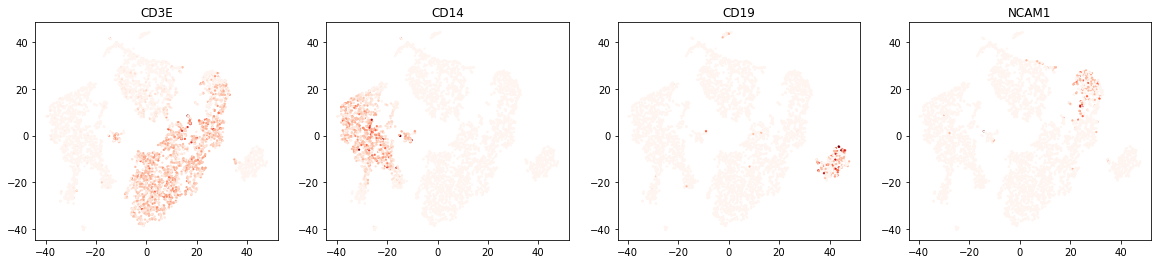

In [9]:
# plot gene markers: CD3E (T cells), CD14 (monocytes), CD19 (B cells), NCAM (NK cells)
marker_genes = ['CD3E', 'CD14', 'CD19', 'NCAM1']
f, axes = plt.subplots(1, len(marker_genes), figsize=(5*len(marker_genes), 4))
for gene, axis in zip(marker_genes, axes):
    expr = get_expression(feature_bc_matrix, gene)
    axis.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

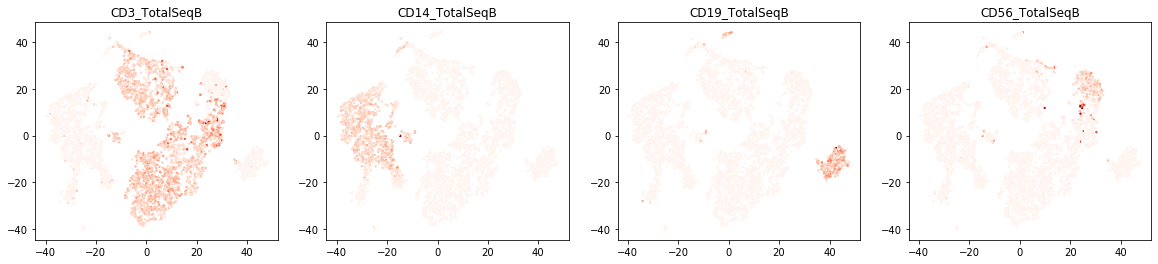

In [10]:
# plot antibody markers: CD3 (T cells), CD14 (monocytes), CD19 (B cells), CD56 (NK cells)
marker_genes = ['CD3_TotalSeqB', 'CD14_TotalSeqB', 'CD19_TotalSeqB', 'CD56_TotalSeqB']
f, axes = plt.subplots(1, len(marker_genes), figsize=(5*len(marker_genes), 4))
for gene, axis in zip(marker_genes, axes):
    expr = get_expression(feature_bc_matrix, gene)
    axis.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()